### RXTE observations provided by dr. Tomaso Belloni (INAF / Brera Astronomical Observatory)

In [1]:
!pip install stingray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 11.1 MB/s eta 0:00:00


In [2]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum
import scipy.stats as ss

This time we try to use the *stingray* package.

In [3]:
def SetPlotPars (px,xlbl="",ylbl="",titlbl="",linwidth=2,tickxfonsiz=24,tickyfonsiz=24,xlblfonsiz=30,ylblfonsiz=30,titlblfonsiz=35):
    #
    # Lines
    [i.set_linewidth(linwidth) for i in px.spines.values()]
    #
    # Ticks
    plt.tick_params(axis='both', which='major', labelsize='xx-large')
    plt.tick_params(axis='both', which='minor', labelsize='x-large')
    #
    for tickx,ticky in zip(px.xaxis.get_major_ticks(),px.yaxis.get_major_ticks()):
        tickx.label1.set_fontsize(tickxfonsiz)
        ticky.label1.set_fontsize(tickyfonsiz)
    #
    # Labels
    plt.xlabel(xlbl,fontsize=xlblfonsiz)
    plt.ylabel(ylbl,fontsize=ylblfonsiz)
    plt.title(titlbl,fontsize=titlblfonsiz)
#

The usual function to have nicer to see plots.

# Data

In [4]:
dt = Table.read('gx339_qpo.lc', hdu=1)
dt.info

<Table length=179201>
  name   dtype    unit  
------- ------- --------
   TIME float64        s
   RATE float64 counts/s
  ERROR float64 counts/s
FRACEXP float64         

FRACEXP is the fraction of a bin of length $\Delta t$ efffectively covered by the observations. We don't need it, but this informatoin can be useful for a careful estimate of the statistics of the light curve.

Let's look at the spacing of the observations.

In [5]:
print("Sampling, mean: {:.2g}s variance: {:.2g}".format(np.diff(dt['TIME']).mean(),np.diff(dt['TIME']).var()))

Sampling, mean: 0.0039s variance: 0


Variance 0 means that all time bins are of the same length.

In [6]:
t = dt['TIME']-dt['TIME'].min()
y = dt['RATE']
ey = dt['ERROR']

In [7]:
lc = Lightcurve(t,y,input_counts=False)
print("Sampling as read by stingray: {:.2g}s".format(lc.dt))

Sampling as read by stingray: 0.0039s


stingray, importing the data, confirms the light curve is evenly sampled.

# Light curve

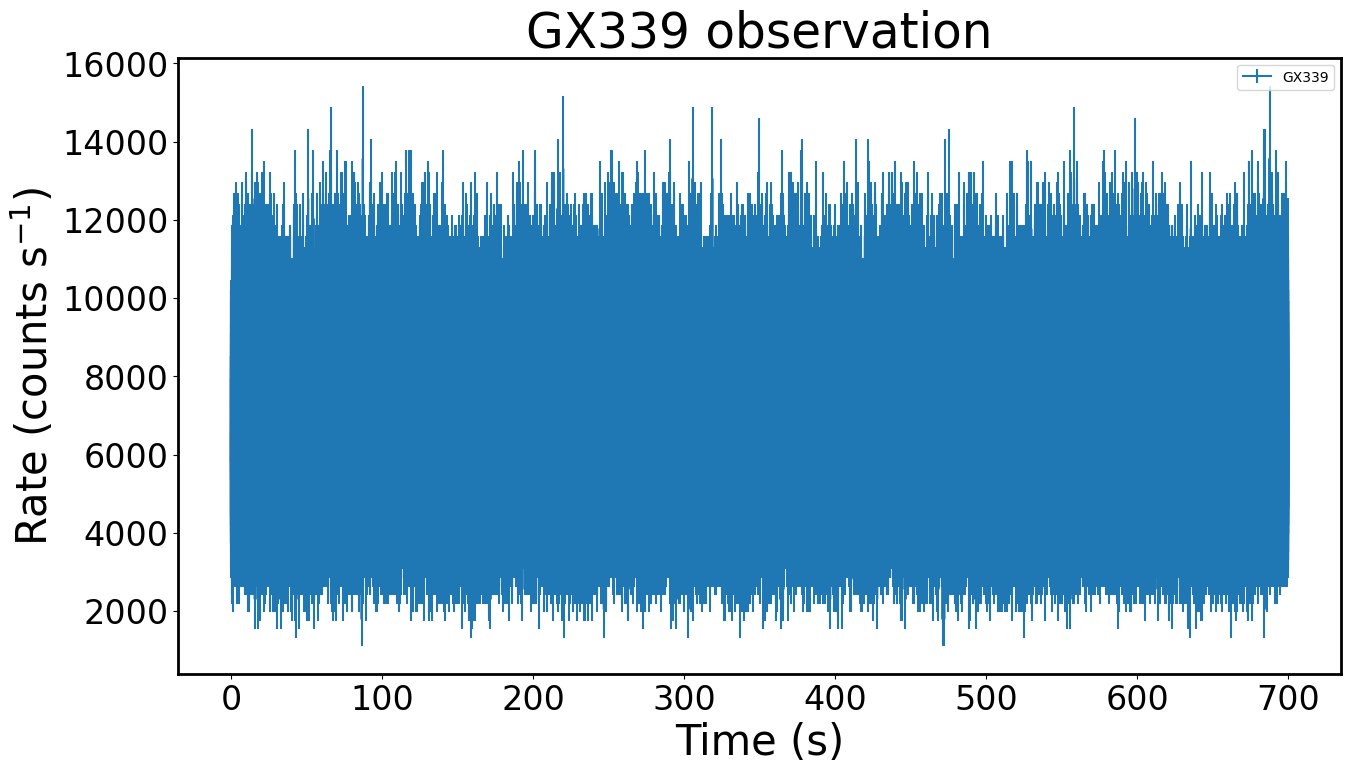

In [8]:
p = plt.figure(figsize=(15,8))
px = p.add_subplot(111)
SetPlotPars(px,"Time (s)","Rate (counts s$^{-1}$)","GX339 observation")
plt.errorbar(t,y,yerr=ey,label='GX339')
plt.legend()
plt.show()

it looks difficult to see the details. With such a rapid sampling we have a very large number of points (almost 180000!). Let's try a zoom.

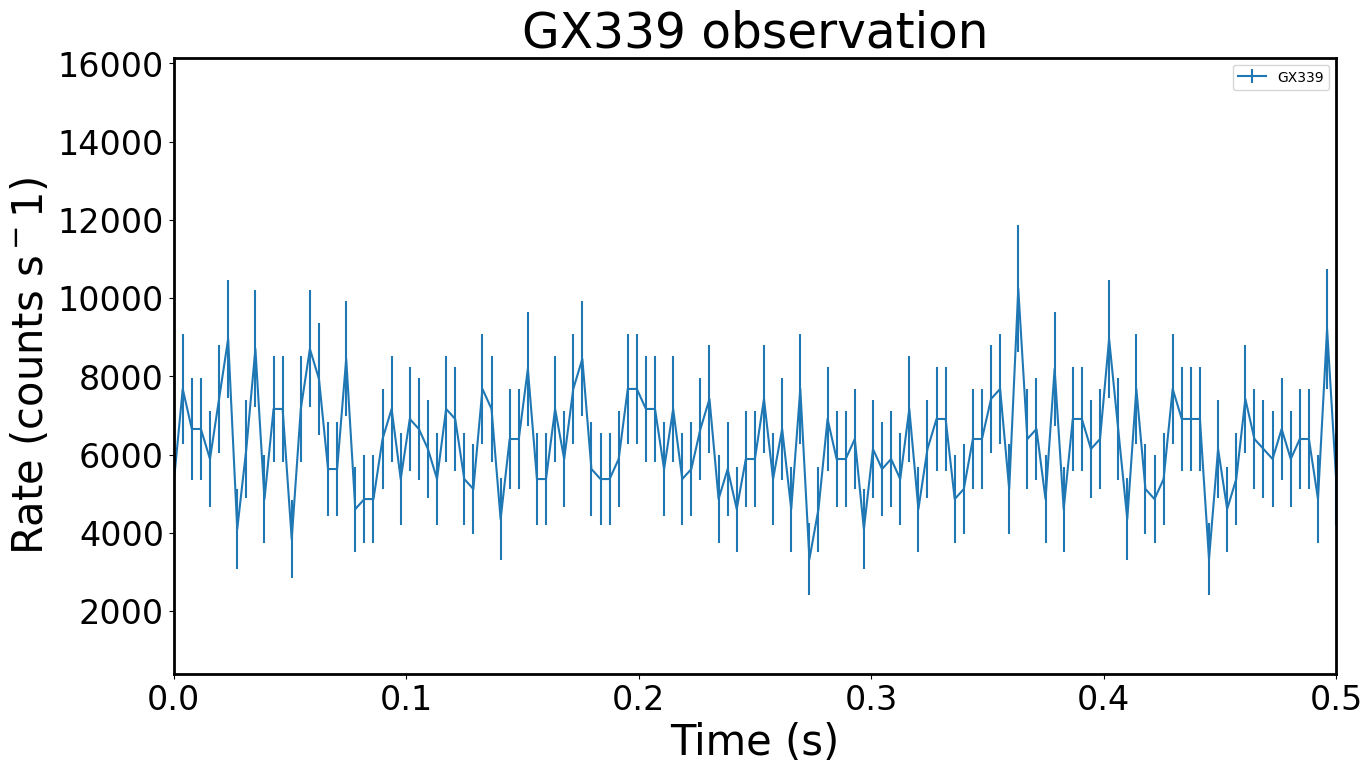

In [9]:
p = plt.figure(figsize=(15,8))
px = p.add_subplot(111)
SetPlotPars(px,"Time (s)","Rate (counts s${^-1}$)","GX339 observation")
plt.errorbar(t,y,yerr=ey,label='GX339')
plt.legend()
plt.xlim((0,0.5))
plt.show()

It is undoubtedly hard to say something. Let's see if our spectral analysis allows us to find somehting.

# Spectral analysis

In [10]:
ps = Powerspectrum(lc,norm='leahy')

We chose the "Leahy" normalization and let's see the periodogram

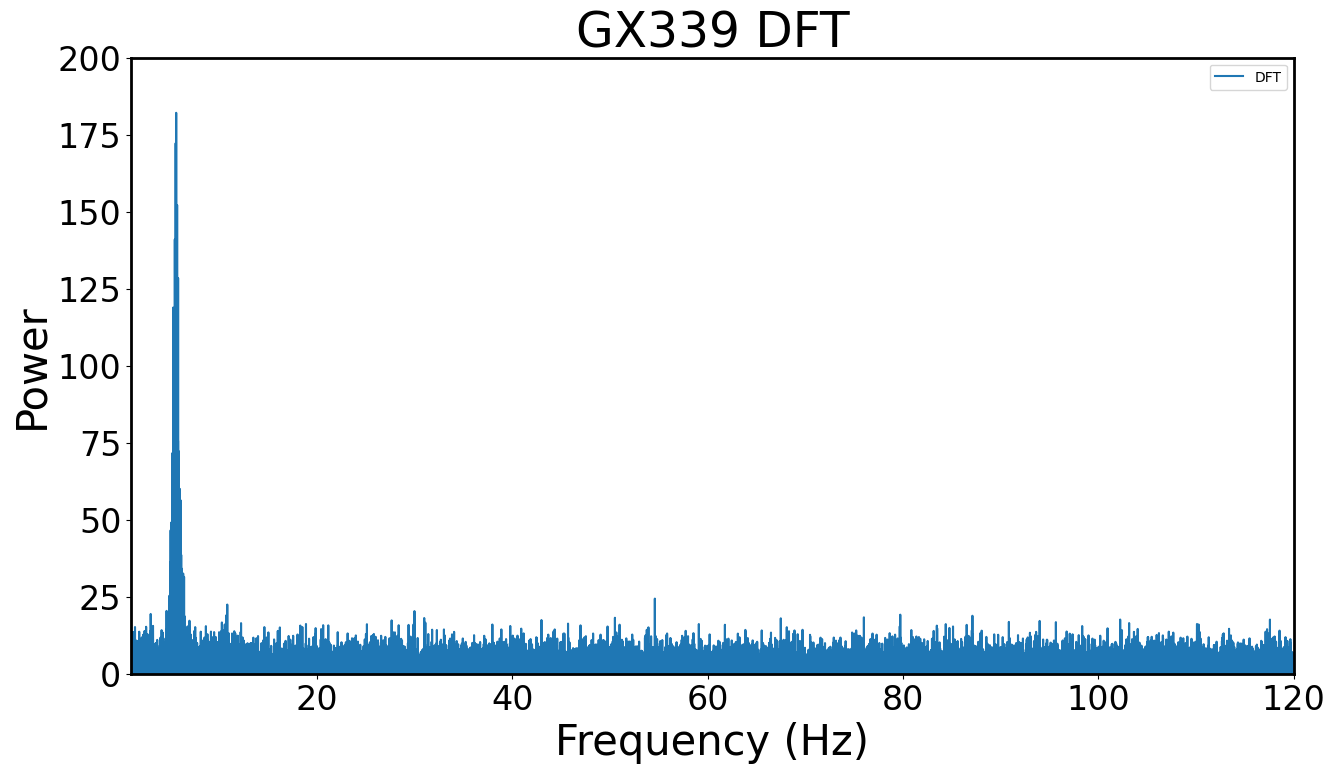

In [11]:
p = plt.figure(figsize=(15,8))
px = p.add_subplot(111)
SetPlotPars(px,"Frequency (Hz)","Power","GX339 DFT")
plt.plot(ps.freq,ps.power,label="DFT")
plt.legend()
plt.xlim((1,120))
plt.ylim((0,200))
plt.show()

We see a very poweful peak. Let's see is with some zoom.

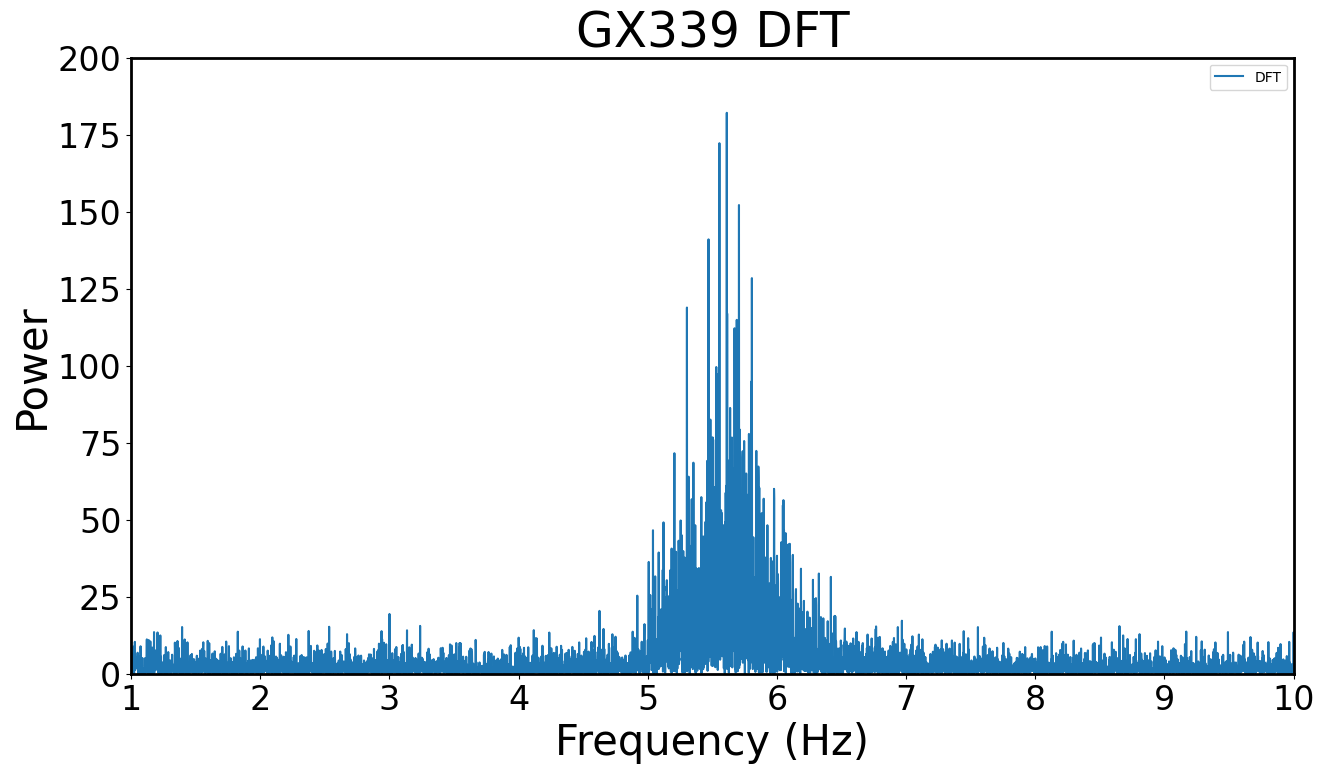

In [12]:
p = plt.figure(figsize=(15,8))
px = p.add_subplot(111)
SetPlotPars(px,"Frequency (Hz)","Power","GX339 DFT")
plt.plot(ps.freq,ps.power,label="DFT")
plt.legend()
plt.xlim((1,10))
plt.ylim((0,200))
plt.show()

And we can see a subtructure in the peak. The peak is close to $\sim$ 5.8 Hz. Let's see if with some rebinning the periodogram changes.

In [13]:
avg_ps = AveragedPowerspectrum(lc, 10., norm='leahy')

70it [00:00, 9101.38it/s]


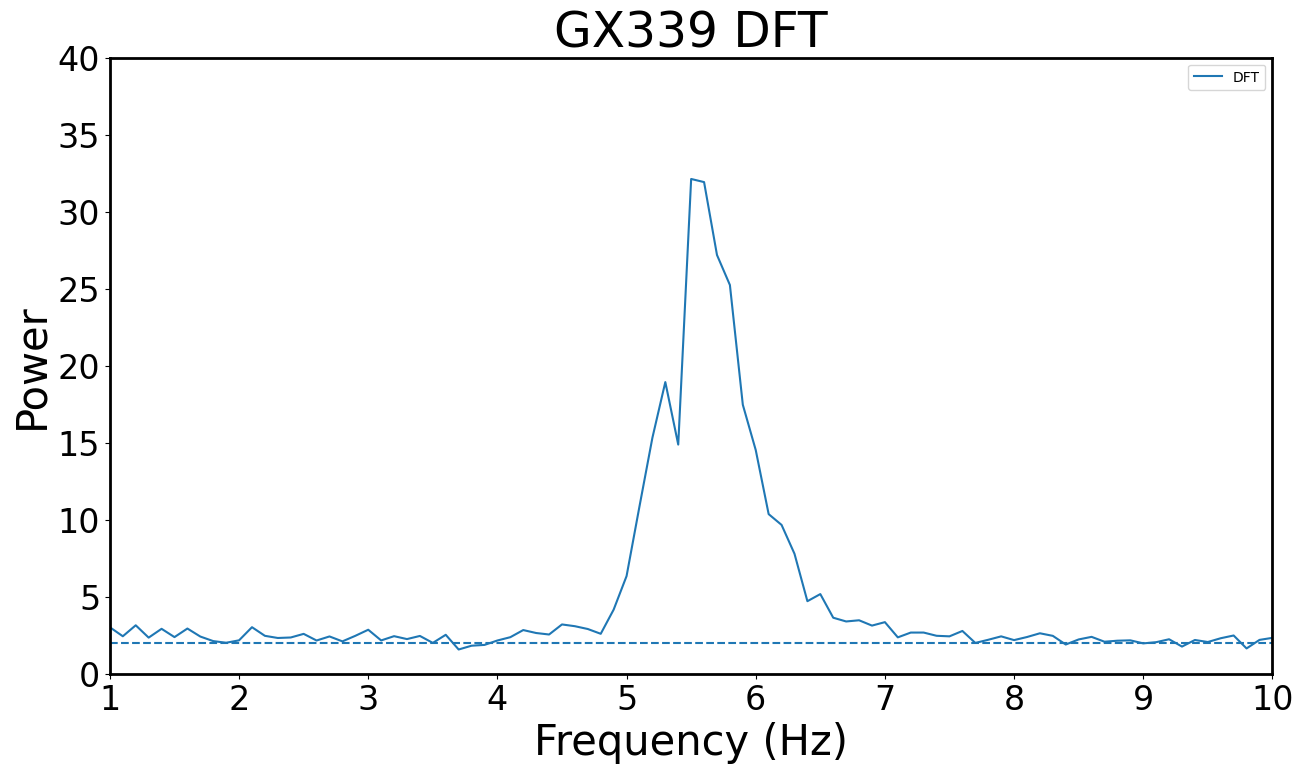

In [14]:
p = plt.figure(figsize=(15,8))
px = p.add_subplot(111)
SetPlotPars(px,"Frequency (Hz)","Power","GX339 DFT")
plt.plot(avg_ps.freq,avg_ps.power,label="DFT")
plt.legend()
plt.axhline(2,ls='--')
plt.xlim((1,10))
plt.ylim((0,40))
plt.show()

In [15]:
flt = (ps.freq > 1) & (ps.freq < 10)
idmax = ps.power[flt].argmax()
fmax =  ps.freq[flt][idmax]
pmax = ps.power[flt][idmax]
nf = len(ps.freq)
nm = ps.m
print(idmax,fmax,pmax,nf,nm)

3227 5.611397257827803 182.11474451225047 89600 1


Let's not forget that any significance has to be computed considering the number of *indipendent frequncies* considered for the analysis.

See below:

In [16]:
eps = 1-0.9997 # 3sigma
print("FAP: {:.2f}%".format(eps*100))
Ppre = (1-eps)
Ppost = (1-eps)**100
print("Single-trial probability: {:.2f}%".format(Ppre*100))
print("Post-trial probability: {:.2f}%".format(Ppost*100))

FAP: 0.03%
Single-trial probability: 99.97%
Post-trial probability: 97.04%


And we can appreciate the reduction in noise and, of course, in frequency resolution too. The Poissonian noise is still 2, as expected.

## Detection significance

Scipy functions can give us what we need. *sf* is *1-cdf*, the *cumulative density function*. Essentially, you compute the probability of obtaining a given value for the power for a $\chi^2$ distribution.

In [17]:
sfap = ss.chi2.sf(pmax,2)
print("Single-trial FAP: {:.2g}".format(sfap))
Ppre = (1-sfap)
Ppost = (1-sfap)**nf
print("Single-trial probability: {:.2f}%".format(Ppre*100))
print("Post-trial probability: {:.2f}%".format(Ppost*100))

Single-trial FAP: 3.7e-06
Single-trial probability: 100.00%
Post-trial probability: 71.61%


The peak it is highly signicant!